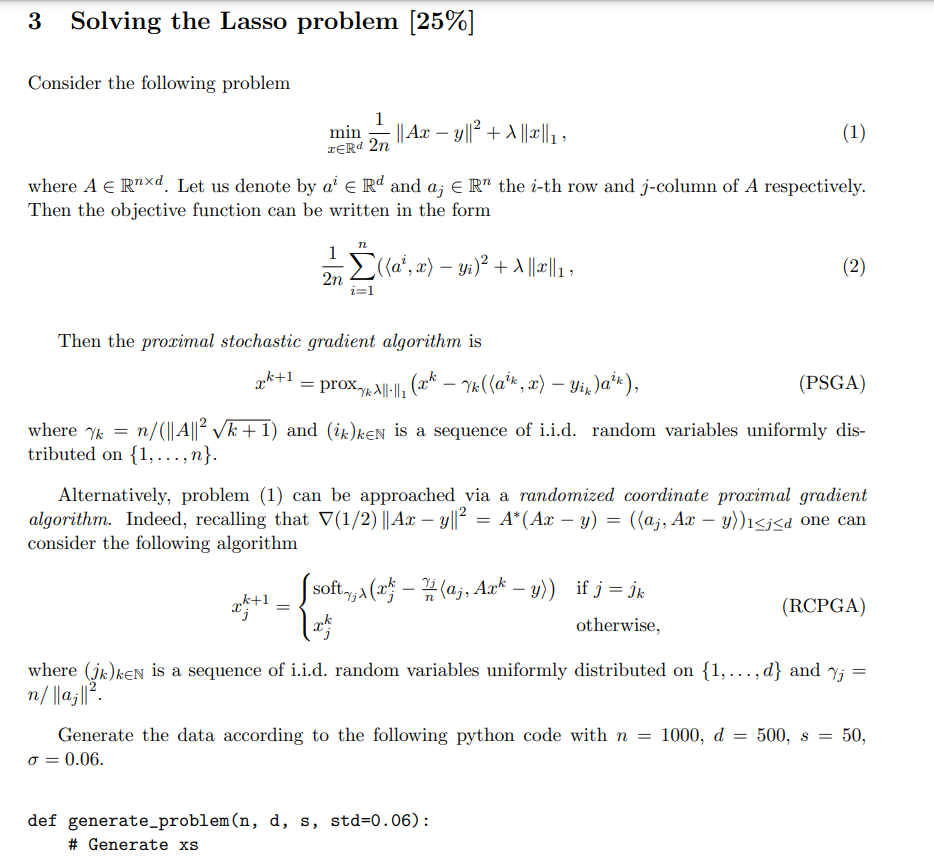
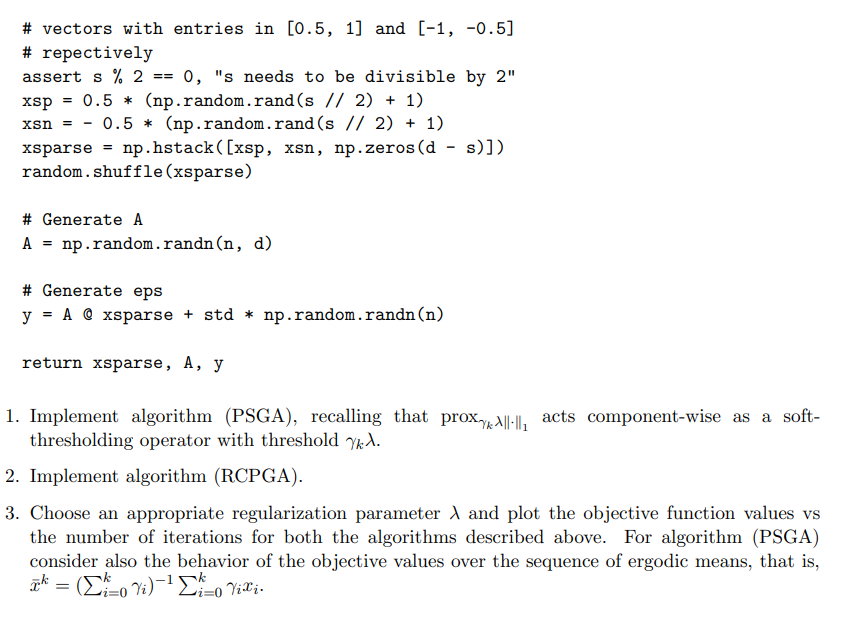

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
def generate_problem(n, d, s, std=0.06):
    # Generate xs
    # vectors with entries in [0.5, 1] and [-1, -0.5]
    # respectively
    assert s % 2 == 0, "s needs to be divisible by 2"
    xsp = 0.5 * (np.random.rand(s // 2) + 1)
    xsn = - 0.5 * (np.random.rand(s // 2) + 1)
    xsparse = np.hstack([xsp, xsn, np.zeros(d - s)])
    random.shuffle(xsparse)
    # Generate A
    A = np.random.randn(n, d)
    # Generate eps
    y = A @ xsparse + std * np.random.randn(n)
    return xsparse, A, y


In [3]:
#generating data
n=1000
x,A,y = generate_problem(n,500,50)

#computing frobenius norm squared now so that don't have to compute each time
FroNormAsqrd = (np.linalg.norm(A, ord='fro'))**2

In [4]:
#objective function
def obj_func(A,x_sol,y,lam,n):
    result = (1.0/(2.0*n))*np.linalg.norm((A@x_sol - y))**2 + lam*np.linalg.norm(x_sol, ord=1)
    return result

#proximity operator for L1 NORM from example 5.1.6 vectorised
def prox_L_one(gamma, t):
    result = (t-gamma)*(t>gamma) + (t+gamma)*(t<-gamma) + 0.0
    return result

#kth iteration of PSGA 
def PSGA_step(A,k,y,lam, n, FroNormAsqrd, previous_val):
    ik = np.random.randint(1, high=n+1) #kth value in random sequence
    xk = previous_val.copy()
    gammak = n/(FroNormAsqrd*np.sqrt(k+1))
    t = xk - gammak*((A[ik - 1,:]@xk) - y[ik-1])*A[ik - 1,:]
    result = prox_L_one(lam*gammak, t)
    return result, gammak

In [5]:
print(obj_func(A,x, y, 0.01,n)) #basline objective function value. This is found using the true value of x

0.38142817341763346


In [6]:
#this cell runs for about 12 mins
#PSGA
max_iters = 1_000_000 # max number of iterations
lam = 0.01 #0.01 chosen for lambda
prev_val = np.random.rand(x.shape[0]) #initialisation of x0
objective_vals_psga = np.empty(max_iters)


gamma_k_sum = 0.0 #sum of gammas for ergodic means
gamma_and_x_sum = 0.0 #sum of gamma*x for ergodic means
objective_vals_psga_ergo = np.empty(max_iters) #ergodic means objective vals


for k in range(1,max_iters+1):
    #normal psga
    new_val, curr_gamma_k = PSGA_step(A,k,y,lam, n, FroNormAsqrd,prev_val)
    prev_val = new_val.copy()
    objective_vals_psga[k-1] = obj_func(A,prev_val, y, lam,n)
    
    #ergodic means 
    gamma_k_sum += curr_gamma_k 
    gamma_and_x_sum += curr_gamma_k*prev_val
    curr_ergodic_mean = gamma_and_x_sum/gamma_k_sum
    objective_vals_psga_ergo[k-1] = obj_func(A,curr_ergodic_mean, y, lam,n)


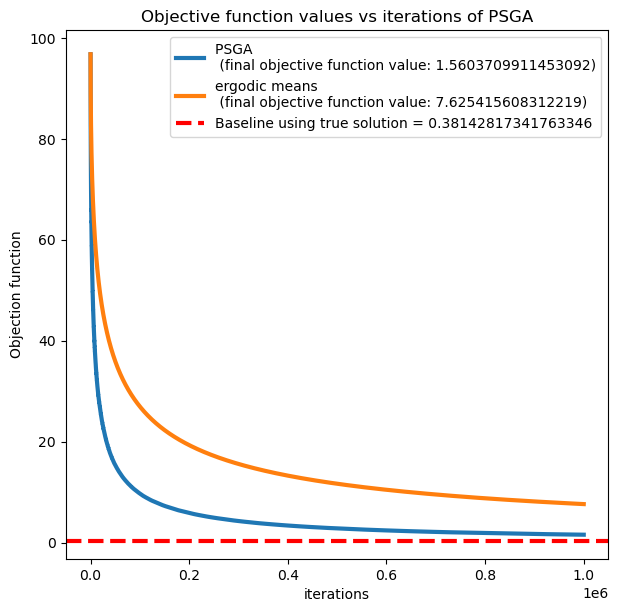

In [7]:
#PSGA and ergodic means PSGA objective function plotted together
plt.figure(figsize=(7,7), dpi=100)
plt.plot(objective_vals_psga, linewidth=3, label='PSGA \n (final objective function value: ' + str(objective_vals_psga[-1]) + ')')
plt.plot(objective_vals_psga_ergo, linewidth=3, label='ergodic means \n (final objective function value: ' + str(objective_vals_psga_ergo[-1]) + ')')
plt.axhline(y=obj_func(A,x, y, 0.01,n), color='red', linewidth=3, linestyle='--', label='Baseline using true solution = ' + str(obj_func(A,x, y, 0.01,n)))
plt.title('Objective function values vs iterations of PSGA')
plt.xlabel('iterations')
plt.ylabel('Objection function')
plt.legend()
plt.show()

As we can see above, we need a large number of iterations to approach the baseline objective function value and using the ergodic means gives a worse performance than the PSGA. Here we used $\lambda$ = 0.01.

In [8]:
def soft(gamma, t):
    result = (t-gamma)*(t>gamma) + (t+gamma)*(t<-gamma) + 0.0
    return result

def RCPGA_step(A,y,lam, n,d, previous_val):
    jk = np.random.randint(1, high=d+1) #kth value in random sequence of chosen dimensions
    xk = previous_val.copy()

    gammaj = n/(np.sum(A[:,jk-1]**2))
    t = xk[jk-1] - (gammaj/n)*(A[:,jk-1] @ (A@xk - y))

    update = soft(gammaj*lam, t) #jk dimension update
    return update, jk

In [9]:
#RCPGA
max_iters = 10_000 # max number of iterations
lam = 0.01 #0.01 chosen for lambda
prev_val = np.random.rand(x.shape[0]) #initialisation of x0
objective_vals_RCPGA = np.empty(max_iters)



for k in range(1,max_iters+1):
    update, jk = RCPGA_step(A,y,lam, n,500, prev_val)
    prev_val[jk-1] = update
    objective_vals_RCPGA[k-1] = obj_func(A,prev_val, y, lam,n)

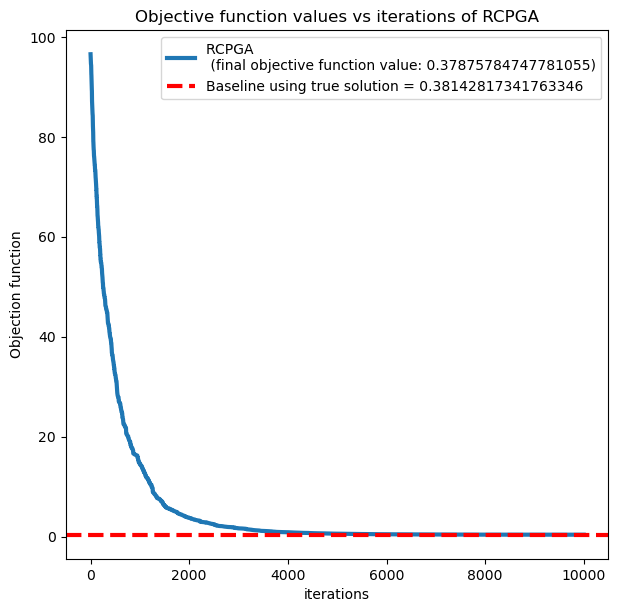

In [10]:
plt.figure(figsize=(7,7), dpi=100)
plt.plot(objective_vals_RCPGA, linewidth=3, label='RCPGA \n (final objective function value: ' + str(objective_vals_RCPGA[-1]) + ')')
plt.axhline(y=obj_func(A,x, y, 0.01,n), color='red', linewidth=3, linestyle='--', label='Baseline using true solution = ' + str(obj_func(A,x, y, 0.01,n)))
plt.title('Objective function values vs iterations of RCPGA')
plt.xlabel('iterations')
plt.ylabel('Objection function')
plt.legend()
plt.show()

As we can see the RCPGA vastly outperforms the PSGA. It gets much closer to the baseline objective function value in 10k iterations whereas PSGA took 1M iterations and still did worse. PSGA takes about 10 mins whereas RCPGA performed better with a run time of about 5 seconds. Here again we used $\lambda$ = 0.01. 